**LOAD DATA**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


train = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")




**EDA**

In [7]:
train.describe()

,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,1.160230e+05,116023.000000,116023.000000,116023.000000,116023.0,1.160230e+05,4281.000000,116015.000000,116023.0,47148.0,1.160230e+05,116023.000000,1.160230e+05,80518.0
mean,2.656393e+07,61094.356231,0.037019,2.691311,1.0,1.493429e+09,1.019622,8.412352,8.0,1.0,2.016860e+07,10.607371,1.493429e+09,1.0
std,2.051825e+08,35240.756859,0.188808,10.451613,0.0,1.528798e+07,0.174517,14.344937,0.0,0.0,6.182322e+03,19.629576,1.528798e+07,0.0
min,0.000000e+00,0.000000,0.000000,1.000000,1.0,1.470035e+09,1.000000,1.000000,8.0,1.0,2.016080e+07,1.000000,1.470035e+09,1.0
25%,0.000000e+00,30603.500000,0.000000,1.000000,1.0,1.480066e+09,1.000000,1.000000,8.0,1.0,2.016112e+07,1.000000,1.480066e+09,1.0
50%,0.000000e+00,61014.000000,0.000000,1.000000,1.0,1.491646e+09,1.000000,2.000000,8.0,1.0,2.017041e+07,2.000000,1.491646e+09,1.0
75%,0.000000e+00,91616.500000,0.000000,2.000000,1.0,1.505079e+09,1.000000,10.000000,8.0,1.0,2.017091e+07,12.000000,1.505079e+09,1.0
max,2.312950e+10,122276.000000,1.000000,447.000000,1.0,1.525157e+09,5.000000,469.000000,8.0,1.0,2.018043e+07,500.000000,1.525157e+09,1.0


In [8]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain columns and types:")
print(train.dtypes)

print("\nMissing values in train data:")
print(train.isnull().sum().sort_values(ascending=False).head(10))

print("\nTarget column statistics:")
print(train['purchaseValue'].describe())

Train shape: (116023, 52)
Test shape: (29006, 51)

Train columns and types:
trafficSource.isTrueDirect                       object
purchaseValue                                   float64
browser                                          object
device.screenResolution                          object
trafficSource.adContent                          object
trafficSource.keyword                            object
screenSize                                       object
geoCluster                                       object
trafficSource.adwordsClickInfo.slot              object
device.mobileDeviceBranding                      object
device.mobileInputSelector                       object
userId                                            int64
trafficSource.campaign                           object
device.mobileDeviceMarketingName                 object
geoNetwork.networkDomain                         object
gclIdPresent                                      int64
device.operatingSystemVersio

NOTE:

* Significant missing values in ad related fields.

* The distribution is extremely skewed:
75% of values are exactly 0;
Mean = ₹26 million, but median is 0; log transformation could help for skewed targets.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


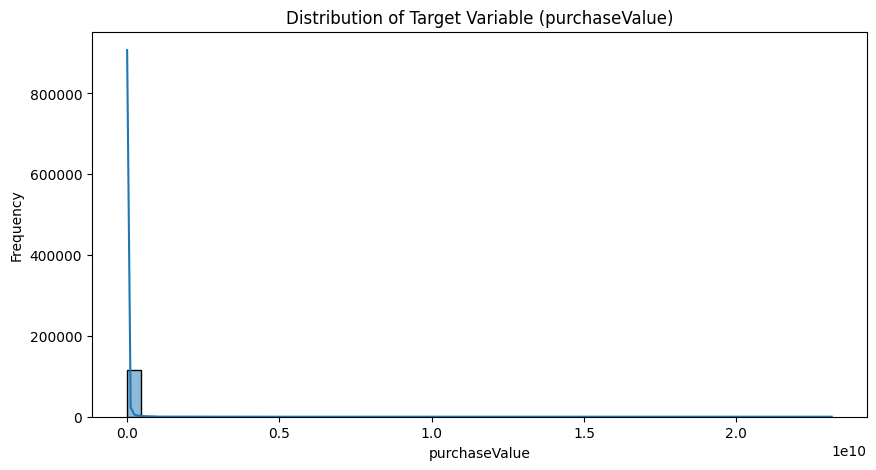

In [10]:
# Distribution of target variable
plt.figure(figsize=(10, 5))
sns.histplot(train['purchaseValue'], bins=50, kde=True)
plt.title("Distribution of Target Variable (purchaseValue)")
plt.xlabel("purchaseValue")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


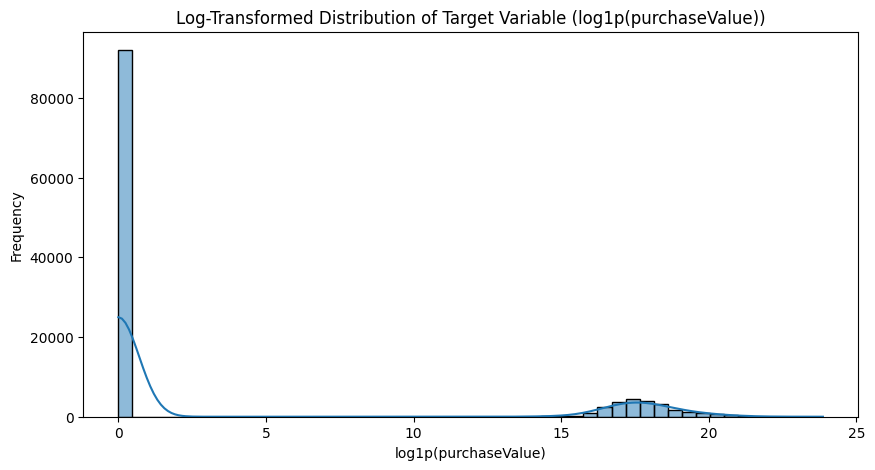

In [11]:
# Log-transform the target to reduce skew and replot
train['purchaseValue_log'] = np.log1p(train['purchaseValue'])

plt.figure(figsize=(10, 5))
sns.histplot(train['purchaseValue_log'], bins=50, kde=True)
plt.title("Log-Transformed Distribution of Target Variable (log1p(purchaseValue))")
plt.xlabel("log1p(purchaseValue)")
plt.ylabel("Frequency")
plt.show()


/tmp/ipykernel_31/355791735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero['purchaseValue_log'] = np.log1p(non_zero['purchaseValue'])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


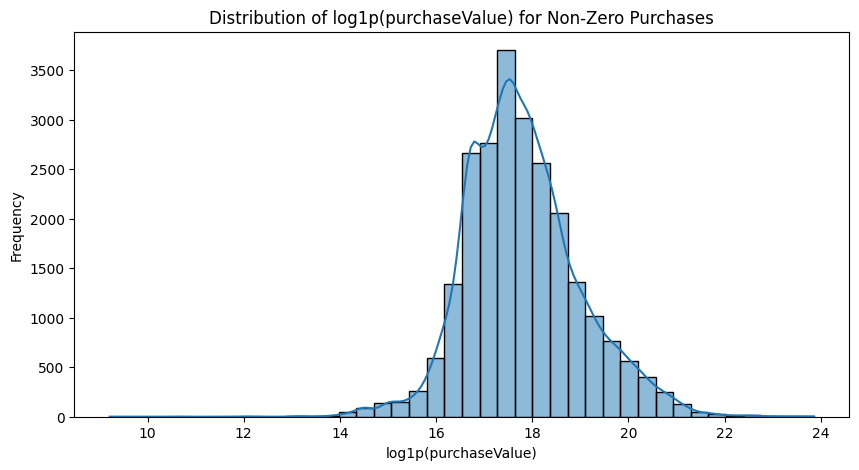

In [12]:
# Filter non-zero purchase values
non_zero = train[train['purchaseValue'] > 0]
non_zero['purchaseValue_log'] = np.log1p(non_zero['purchaseValue'])

plt.figure(figsize=(10, 5))
sns.histplot(non_zero['purchaseValue_log'], bins=40, kde=True)
plt.title("Distribution of log1p(purchaseValue) for Non-Zero Purchases")
plt.xlabel("log1p(purchaseValue)")
plt.ylabel("Frequency")
plt.show()


Note : Log-transforming non-zero purchases shows a near-normal distribution

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


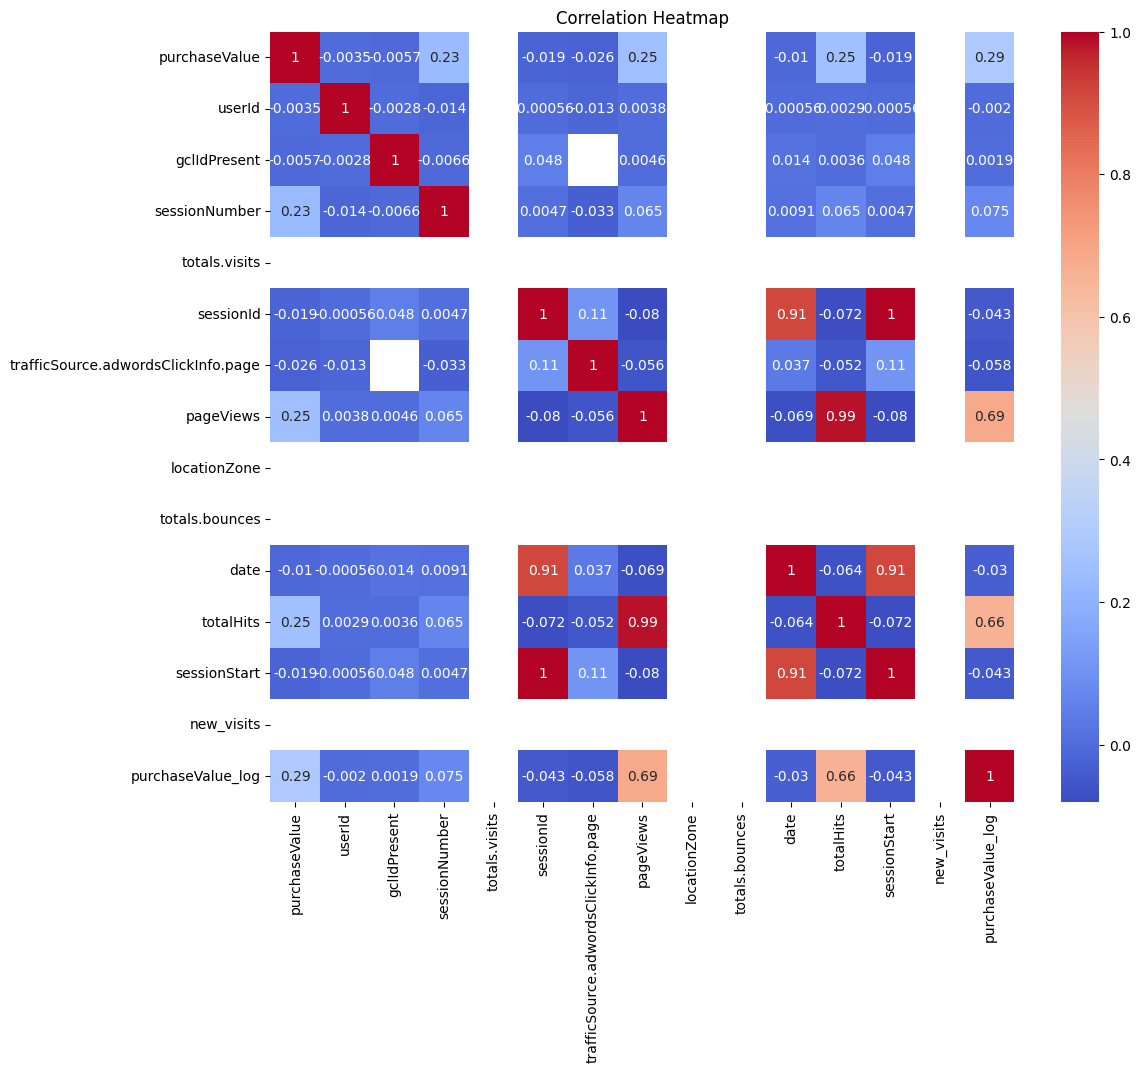

In [13]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 10))
num_cols = train.select_dtypes(include=[np.number]).columns
sns.heatmap(train[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


Note :

* No strong predictors: Most numerical features show weak correlation with purchaseValue, indicating the need for richer features or interactions.
* Redundancy exists: High correlation between totalHits, pageViews, and totals.visits suggests possible feature redundancy.
* Certain fields are not reflecting in the heatmap as they have only one value.

In [15]:
# cardinality of each column
cardinality = train.nunique().sort_values(ascending=False)

print("Cardinality of each column:")
print(cardinality)

Cardinality of each column:
sessionStart                                    107388
sessionId                                       107379
userId                                          100499
purchaseValue                                     6766
purchaseValue_log                                 6766
trafficSource.referralPath                         941
geoNetwork.city                                    695
date                                               638
trafficSource.keyword                              566
geoNetwork.region                                  388
sessionNumber                                      230
totalHits                                          225
locationCountry                                    193
pageViews                                          175
trafficSource                                      161
geoNetwork.metro                                   104
trafficSource.adContent                             53
browser                              

In [16]:
correlations = train[num_cols].corr()['purchaseValue'].drop('purchaseValue')
print("Top 5 correlated features with purchaseValue:")
print(correlations.abs().sort_values(ascending=False).head(5))

Top 5 correlated features with purchaseValue:
purchaseValue_log                      0.288212
totalHits                              0.251651
pageViews                              0.248454
sessionNumber                          0.230585
trafficSource.adwordsClickInfo.page    0.025839
Name: purchaseValue, dtype: float64


Note:

* Higher totalHits and pageViews suggest more engaged sessions, mildly linked to higher purchases
* Higher sessionNumber hints that returning users may be more likely to purchase.
* Also saw some white spaces in the heatmap, indicating columns with either mostly missing or had only one unique value.


So, removed such columns that had either more than 99% missing values, only a single unique value, or acted as high-cardinality identifiers with little predictive value.

In [ ]:
#do not run

sparse_cols = train.columns[train.isnull().mean() > 0.95]
constant_cols = train.columns[train.nunique(dropna=False) <= 1]
drop_candidates = list(set(sparse_cols) | set(constant_cols))

additional_drops = [ 'sessionId', 'userId']

print("Dropping columns due to high sparsity, low variance, or identifier nature:")
print(drop_candidates + additional_drops)

train.drop(columns=drop_candidates + additional_drops, inplace=True, errors='ignore')
test.drop(columns=drop_candidates + additional_drops, inplace=True, errors='ignore')




**FEATURE ENGINEERING**:

Extracted new time-based and ratio features, applied frequency encoding on selected high-cardinality categorical columns, and dropped original datetime fields.

We applied frequency encoding on high-cardinality categorical features such as geoNetwork.city, trafficSource.keyword, and trafficSource.campaign to convert them into meaningful numerical features without increasing dimensionality.

PREPROCESS :

We handled missing values with -1 imputation
Label encoding for general object categories

In [18]:
train = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")


def feature_engineering(df):
    df = df.copy()
    
    # Date features
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    # Time features
    df['sessionStart'] = pd.to_datetime(df['sessionStart'], errors='coerce')
    df['session_hour'] = df['sessionStart'].dt.hour
    df['session_day'] = df['sessionStart'].dt.day

    # Ratios
    df['hits_per_pageview'] = df['totalHits'] / (df['pageViews'] + 1e-5)
    df['bounce_rate'] = df['totals.bounces'] / (df['totals.visits'] + 1e-5)

    # Frequency encoding
    for col in ['geoNetwork.city', 'trafficSource.keyword', 'trafficSource.campaign']:
        freq_map = df[col].value_counts().to_dict()
        df[col + '_freq'] = df[col].map(freq_map)

    # Drop raw datetime columns
    df.drop(['date', 'sessionStart'], axis=1, inplace=True)

    return df


def preprocess(df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    # Drop high-sparsity, constant, or ID columns
    sparse_cols = df_train.columns[df_train.isnull().mean() > 0.99]
    constant_cols = df_train.columns[df_train.nunique(dropna=False) <= 1]
    id_cols = ['sessionId', 'userId']

    drop_cols = list(set(sparse_cols) | set(constant_cols) | set(id_cols))
    df_train.drop(columns=drop_cols, inplace=True, errors='ignore')
    df_test.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Label encode object-type columns
    for col in df_train.select_dtypes(include='object').columns:
        le = LabelEncoder()
        combined = pd.concat([df_train[col], df_test[col]], axis=0).astype(str)
        le.fit(combined)
        df_train[col] = le.transform(df_train[col].astype(str))
        df_test[col] = le.transform(df_test[col].astype(str))

    # Fill missing values
    df_train.fillna(-1, inplace=True)
    df_test.fillna(-1, inplace=True)

    return df_train, df_test

train = feature_engineering(train)
test = feature_engineering(test)

train, test = preprocess(train, test)


**TRAIN VALIDATION SPLIT**

In [19]:
X_train = train.drop('purchaseValue', axis=1)
y_train = train['purchaseValue']
X_test = test[X_train.columns]

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [7]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)

# Predictions
train_preds = model.predict(X_tr)
val_preds = model.predict(X_val)

# Metrics
rmse = mean_squared_error(y_val, val_preds, squared=False)
r2_train = r2_score(y_tr, train_preds)
r2_val = r2_score(y_val, val_preds)

# Output
print(f"Train R²: {r2_train:.4f}")
print(f" Validation R²: {r2_val:.4f}")
print(f" Validation RMSE: {rmse:.4f}")




Train R²: 0.9301
 Validation R²: 0.1346
 Validation RMSE: 202254800.2153


Clearly model is overfitting.


 Final Model Training & Submission

In [8]:
# Final Model Training & Submission (raw target)
model.fit(X_train, y_train)
preds = model.predict(X_test)

submission = pd.DataFrame({'id': sample_submission['ID'], 'purchaseValue': preds})
submission.to_csv('24DS1000028fex.csv', index=False)


 Hyperparameter Tuning for Random Forest

In [10]:

from sklearn.model_selection import train_test_split, GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8,16],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_tr, y_tr)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds, squared=False)
print(f"Validation RMSE after tuning: {rmse:.4f}")

from sklearn.metrics import r2_score

# R² scores for best model
train_preds = best_model.predict(X_tr)
r2_train = r2_score(y_tr, train_preds)
r2_val = r2_score(y_val, val_preds)

print(f" Best Model Train R²:      {r2_train:.4f}")
print(f" Best Model Validation R²: {r2_val:.4f}")


best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

submission = pd.DataFrame({'id': sample_submission['ID'], 'purchaseValue': preds})
submission.to_csv('24DS1000028rfht.csv', index=False)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Validation RMSE after tuning: 203108394.6851
 Best Model Train R²:      0.7746
 Best Model Validation R²: 0.1273


RF, XGB, LIGHTGBM without HPT

In [13]:

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


#  Random Forest (Tuned)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_tr, y_tr)
val_preds_rf = rf_model.predict(X_val)
rmse_rf = mean_squared_error(y_val, val_preds_rf, squared=False)
print(f"Random Forest Validation RMSE: {rmse_rf:.4f}")

# XGBoost (Baseline)
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=False)
val_preds_xgb = xgb_model.predict(X_val)
rmse_xgb = mean_squared_error(y_val, val_preds_xgb, squared=False)
print(f"XGBoost Validation RMSE: {rmse_xgb:.4f}")

#LightGBM (Baseline)
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)


lgb_model.fit(X_tr, y_tr)

val_preds_lgb = lgb_model.predict(X_val)
rmse_lgb = mean_squared_error(y_val, val_preds_lgb, squared=False)
print(f"LightGBM Validation RMSE: {rmse_lgb:.4f}")




# Final Predictions with Lower-End Clipping Only

# Random Forest
rf_model.fit(X_train, y_train)
final_preds_rf = rf_model.predict(X_test)
final_preds_rf = np.clip(final_preds_rf, 0, None)  # Only clip negatives

submission_rf = pd.DataFrame({'id': sample_submission['ID'], 'purchaseValue': final_preds_rf})
submission_rf.to_csv('24DS1000028_rf_clip0.csv', index=False)

# XGBoost
xgb_model.fit(X_train, y_train)
final_preds_xgb = xgb_model.predict(X_test)
final_preds_xgb = np.clip(final_preds_xgb, 0, None)

submission_xgb = pd.DataFrame({'id': sample_submission['ID'], 'purchaseValue': final_preds_xgb})
submission_xgb.to_csv('24DS1000028_xgb_clip0.csv', index=False)

# LightGBM
lgb_model.fit(X_train, y_train)
final_preds_lgb = lgb_model.predict(X_test)
final_preds_lgb = np.clip(final_preds_lgb, 0, None)

submission_lgb = pd.DataFrame({'id': sample_submission['ID'], 'purchaseValue': final_preds_lgb})
submission_lgb.to_csv('24DS1000028_lgb_clip0.csv', index=False)

from sklearn.metrics import r2_score

# R² scores
r2_rf = r2_score(y_val, val_preds_rf)
r2_xgb = r2_score(y_val, val_preds_xgb)
r2_lgb = r2_score(y_val, val_preds_lgb)

print("\n R² Comparison Summary")
print(f"Random Forest (tuned):      {r2_rf:.4f}")
print(f"XGBoost (baseline):         {r2_xgb:.4f}")
print(f"LightGBM (baseline):        {r2_lgb:.4f}")


Random Forest Validation RMSE: 203311291.8702


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost Validation RMSE: 194139703.2892
LightGBM Validation RMSE: 198683187.4169

 R² Comparison Summary
Random Forest (tuned):      0.1255
XGBoost (baseline):         0.2026
LightGBM (baseline):        0.1649


NOTE: XGB is performing the best on Validation set, however when these output files are submitted to be run on test set, the score obtained there does not much reflect the results of validation set here. 

In [ ]:
submission_xgb['purchaseValue'].describe()


**Hyperparameter Tuning - XGBoost**

In [17]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

# --- XGBoost Hyperparameter Tuning with Discrete Values ---
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_tr, y_tr)
xgb_best = xgb_search.best_estimator_

# Train and validation predictions
train_preds_xgb = xgb_best.predict(X_tr)
val_preds_xgb = xgb_best.predict(X_val)

# R² scores
r2_train_xgb = r2_score(y_tr, train_preds_xgb)
r2_val_xgb = r2_score(y_val, val_preds_xgb)

print(f" XGBoost R² on Train:      {r2_train_xgb:.4f}")
print(f" XGBoost R² on Validation: {r2_val_xgb:.4f}")
print(f" Best Parameters: {xgb_search.best_params_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
 XGBoost R² on Train:      0.8066
 XGBoost R² on Validation: 0.2643
 Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [18]:

# Train on full training set
xgb_best.fit(X_train, y_train)

# Predict on test set
final_preds_xgb_tuned = xgb_best.predict(X_test)

# Clip negative predictions
final_preds_xgb_tuned = np.clip(final_preds_xgb_tuned, 0, None)

# Create submission DataFrame
submission_xgb_tuned = pd.DataFrame({
    'id': sample_submission['ID'],
    'purchaseValue': final_preds_xgb_tuned
})

# Save to CSV
submission_xgb_tuned.to_csv('24DS1000028_xgbTunedbest.csv', index=False)



Hyperparameter Tuning - LightGBM

In [21]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

# --- LightGBM Hyperparameter Tuning ---
lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_search = RandomizedSearchCV(
    LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    param_distributions=lgb_param_grid,
    n_iter=6,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgb_search.fit(X_tr, y_tr)
lgb_best = lgb_search.best_estimator_

# Predictions & R²
train_preds_lgb = lgb_best.predict(X_tr)
val_preds_lgb = lgb_best.predict(X_val)

r2_train_lgb = r2_score(y_tr, train_preds_lgb)
r2_val_lgb = r2_score(y_val, val_preds_lgb)

print(f" LightGBM R² on Train:      {r2_train_lgb:.4f}")
print(f" LightGBM R² on Validation: {r2_val_lgb:.4f}")
print(f" Best Parameters: {lgb_search.best_params_}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
 LightGBM R² on Train:      0.4961
 LightGBM R² on Validation: 0.1544
 Best Parameters: {'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, num_leaves=20, subsample=0.8; total time=  57.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=31, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=20, subsample=1.0; total time=  59.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=20, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=200, num_leaves=20, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=1

NOTE: LGBM did not give great generalization and has had the poorest performance on train set out of the three tested.

FINAL with score 0.51 - working best without dropping cols for now. 

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load data
train = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
sample_submission = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv")

# Feature engineering function
def feature_engineering(df):
    df = df.copy()

    # Date features
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    # Time features
    df['sessionStart'] = pd.to_datetime(df['sessionStart'], errors='coerce')
    df['session_hour'] = df['sessionStart'].dt.hour
    df['session_day'] = df['sessionStart'].dt.day

    # Ratios
    df['hits_per_pageview'] = df['totalHits'] / (df['pageViews'] + 1e-5)
    df['bounce_rate'] = df['totals.bounces'] / (df['totals.visits'] + 1e-5)

    # Frequency encoding
    for col in ['geoNetwork.city', 'trafficSource.keyword', 'trafficSource.campaign']:
        freq_map = df[col].value_counts().to_dict()
        df[col + '_freq'] = df[col].map(freq_map)

    # Drop original datetime columns
    df.drop(['date', 'sessionStart'], axis=1, inplace=True)

    return df

# Apply feature engineering
train_fe = feature_engineering(train)
test_fe = feature_engineering(test)

# Preprocessing function
def preprocess(df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    for col in df_train.select_dtypes(include='object').columns:
        le = LabelEncoder()
        combined = pd.concat([df_train[col], df_test[col]], axis=0).astype(str)
        le.fit(combined)
        df_train[col] = le.transform(df_train[col].astype(str))
        df_test[col] = le.transform(df_test[col].astype(str))

    df_train.fillna(-1, inplace=True)
    df_test.fillna(-1, inplace=True)

    return df_train, df_test

# Apply preprocessing to feature-engineered data
train_processed, test_processed = preprocess(train_fe, test_fe)

# Split data
X_train = train_processed.drop('purchaseValue', axis=1)
y_train = train_processed['purchaseValue']
X_test = test_processed[X_train.columns]

# Train-validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)

# Predictions on validation and train set
val_preds = model.predict(X_val)
train_preds = model.predict(X_tr)

# Metrics

val_r2 = r2_score(y_val, val_preds)
train_r2 = r2_score(y_tr, train_preds)

# Print results

print("Train R² score:", train_r2)

print("Validation R² score:", val_r2)

# Final model training on full data
model.fit(X_train, y_train)

# Predict on test set
preds = model.predict(X_test)

# Save submission
submission = pd.DataFrame({'id': sample_submission['ID'], 'purchaseValue': preds})
submission.to_csv('24DS1000028fe.csv', index=False)


Train R² score: 0.940883156065309
Validation R² score: 0.08182254629332497
